In [1]:

import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\15726\anaconda3\envs\ds-1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
review_data_or = pd.read_json('Clothing_Shoes_and_Jewelry_5.json',lines=True)

In [3]:
review_data_or.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
review_data_or.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      278677 non-null  object
 1   asin            278677 non-null  object
 2   reviewerName    278225 non-null  object
 3   helpful         278677 non-null  object
 4   reviewText      278677 non-null  object
 5   overall         278677 non-null  int64 
 6   summary         278677 non-null  object
 7   unixReviewTime  278677 non-null  int64 
 8   reviewTime      278677 non-null  object
dtypes: int64(2), object(7)
memory usage: 19.1+ MB


In [5]:
review_data=review_data_or.drop(['reviewerID','asin','reviewerName','summary'],axis=1)


In [6]:
from datetime import datetime
current_date = datetime.now()
# Define a function to calculate the time difference in days
def calculate_time_difference(review_time):
    return (current_date - datetime.strptime(review_time, "%m %d, %Y")).days

# Apply the function to the 'reviewTime' column and replace it
review_data['Review_Interval_Days'] = review_data['reviewTime'].apply(calculate_time_difference)
review_data = review_data.drop(['reviewTime'],axis=1)


In [7]:
review_data['reviewText'] = review_data['reviewText'].astype('string')


In [8]:
review_data.head()

,helpful,reviewText,overall,unixReviewTime,Review_Interval_Days
0,"[0, 0]",This is a great tutu and at a really great pri...,5,1297468800,4634
1,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,1358553600,3927
2,"[0, 0]",What can I say... my daughters have it in oran...,5,1357257600,3942
3,"[0, 0]","We bought several tutus at once, and they are ...",5,1398556800,3464
4,"[0, 0]",Thank you Halo Heaven great product for Little...,5,1394841600,3507


In [9]:
reviews = review_data

reviews[['helpful','total']] = pd.DataFrame(reviews.helpful.values.tolist(), index=reviews.index)
############删掉没有评价是否有用的评论############################
reviews = reviews[reviews['total'] > 0]
#reviews["sentiment"] = reviews["overall"].apply(lambda score: 1 if score > 3 else 1)
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)
#.apply(lambda n: "useful" if n > 0.8 else "useless")

review_data = reviews.drop(['helpful','total'],axis=1)
review_data.head(10)


C:\Users\15726\AppData\Local\Temp\ipykernel_7360\3796216857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)


,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
9,For what I paid for two tutus is unbeatable an...,5,1349568000,4031,0.875000
13,Full and well stitched. This tutu is a beauti...,5,1361664000,3891,1.000000
22,"Prompt delivery, and it is exactly as describe...",4,1365552000,3846,0.500000
23,The minute I saw this my heart skipped a beat....,5,1383782400,3635,1.000000
24,Love this Jewelry Box so well put together ho...,5,1390089600,3562,0.000000
25,This products is great for anyone with a lot o...,5,1348444800,4044,0.500000
30,"The product itself is five stars, however the ...",4,1322956800,4339,0.980488
31,The first question was which computers to inst...,4,1285027200,4778,0.833333
32,"Okay, I admit it. I'm one of the millions of A...",5,1308182400,4510,0.846154
33,I bought this product a little over a year ago...,1,1348185600,4047,0.774194


In [10]:
a = review_data['overall'].value_counts()
print(a)

5    46636
4    17300
3    10670
2     6420
1     5995
Name: overall, dtype: int64


# Data Cleaning

In [11]:
count = 0
for i in review_data['reviewText']:
    if i == '':
        
        count = count+1
count

18

In [12]:
review_data = review_data[review_data['reviewText'] != '']

In [13]:
import nltk
#nlp = spacy.load("en_core_web_sm")
# 下载NLTK的punkt句子分割模型（只需要执行一次）
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def split_sentences(text):

  try:
   punctuation = ['.', '!', '?']
    
        # 去除句子末尾的空格
   text = text.rstrip()
    
     # 检查句末是否有标点符号
   if text[-1] not in punctuation:
        # 如果没有标点符号，就添加一个句号
      text = f'{text}.'
   #sentences = sent_tokenize(text)

   return text
  except Exception as e:
    print(f"Error: {e}, Text: {text}")


review_data['reviewText']= review_data['reviewText'].apply(split_sentences)
#sample =split_sentences( review_data['reviewText'][9827])
#sample


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
review_data.head()

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
9,For what I paid for two tutus is unbeatable an...,5,1349568000,4031,0.875
13,Full and well stitched. This tutu is a beauti...,5,1361664000,3891,1.000
22,"Prompt delivery, and it is exactly as describe...",4,1365552000,3846,0.500
23,The minute I saw this my heart skipped a beat....,5,1383782400,3635,1.000
24,Love this Jewelry Box so well put together ho...,5,1390089600,3562,0.000


# SMOG指数可读性分析
SMOG指数是一种用于评估文本可读性的指标，它考虑了一个文本中的多音节词的数量。SMOG代表了“Simple Measure of Gobbledygook”（即“混乱简单度量”），是由罗伯特·克拉斯特（Robert Gunning）于1952年提出的。它旨在提供一个简单但有效的方法来估计一段文本的阅读难易程度。

In [15]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87003 entries, 9 to 278676
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewText            87003 non-null  object 
 1   overall               87003 non-null  int64  
 2   unixReviewTime        87003 non-null  int64  
 3   Review_Interval_Days  87003 non-null  int64  
 4   usefulScore           87003 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ MB


In [16]:
sample_data = review_data.sample(n=10000, random_state=42)

In [17]:
sample_data

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
149351,for a nice fit under your pants these are grea...,5,1348099200,4048,1.000000
127059,I bought this for my daughter to help keep her...,1,1356739200,3948,0.750000
246096,This is a really sexy dress! It fits me well. ...,5,1379462400,3685,0.000000
245227,"I usually wear stainless steel watches, but I ...",5,1371081600,3782,1.000000
8446,These Daniel Green slippers are just wonderful...,5,1362700800,3879,1.000000
...,...,...,...,...,...
238410,This product is nice .for the price tore the f...,1,1398643200,3463,0.000000
159464,I'm always weary when purchasing designer mark...,5,1375056000,3736,0.916667
262329,I absolutely love the style and color of this ...,4,1382572800,3649,0.916667
28991,"First note, the conservative fit only applies ...",3,1387670400,3590,1.000000


In [18]:
sample_data.reviewText

149351    for a nice fit under your pants these are grea...
127059    I bought this for my daughter to help keep her...
246096    This is a really sexy dress! It fits me well. ...
245227    I usually wear stainless steel watches, but I ...
8446      These Daniel Green slippers are just wonderful...
                                ...                        
238410    This product is nice .for the price tore the f...
159464    I'm always weary when purchasing designer mark...
262329    I absolutely love the style and color of this ...
28991     First note, the conservative fit only applies ...
145502    im not that into Toms as i feel like the craft...
Name: reviewText, Length: 10000, dtype: object

In [19]:
from textatistic import Textatistic

# 定义一个函数来计算SMOG指数
def calculate_smog(text):
    try:
        stats = Textatistic(text)
        return stats.smog_score
    except Exception as e:
        print(f"Error calculating SMOG for text: {e}/n{text}")
        return 0

# 示例用法
readability_scores = []

for i in sample_data.reviewText:
    smog = calculate_smog(i)
    readability_scores.append(smog)

sample_data['Readability_smog'] = readability_scores


Error calculating SMOG for text: Word to be hyphenated may have at most 100 characters./nI had to wait for two shippings before it finally arrived.The skirt is BEAUTIFUL!It arrived a bit wrinkled, so I put it in the dryer to loosen up wrinkles.  Am going to order some tops to match it before I wear it to a party.It is gorgeous!  I love to dance at parties and swirl and twirl, and let my fluffy slips show underneath.  I have a red one, and a matching blue one I already own.  But waiting for the perfect top to go with it.Some tops require too much care, like hand washing or such.  These below seem the most easy care, but I'll still take it easy when washing them.These are the blouses I've considered purchasing with it:I wanted something to match the color, so I could wear the top with blue jeans.  Amazon has many more similar blouses, but they were in the tiny sizes.  (April 12, 2012)*http://www.amazon.com/gp/product/B0065LVD9K/ref=ox_sc_act_title_2?ie=UTF8&m;=A1CGZU4902OKFJ*http://www.a

In [20]:
from textstat import flesch_kincaid_grade, gunning_fog


# 示例用法
flesch_scores = []
gunning_scores = []

for i in sample_data.reviewText:
    fk_score = flesch_kincaid_grade(i)
    gf_score = gunning_fog(i)
    flesch_scores.append(fk_score)
    gunning_scores.append(gf_score)

sample_data['Readability_flesch'] = flesch_scores
sample_data['Readability_Gunning'] = gunning_scores

In [21]:
###字符
##单词数
sample_data['Readability_char_count'] = sample_data['reviewText'].apply(len)

# 计算单词数并添加为新列 'Word_Count'
sample_data['Word_Count'] = sample_data['reviewText'].apply(lambda x: len(x.split()))


## Test of SentimentIntensity Analysis极性分析


In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#sample_review = review_data.reviewText[:10]
Review_Polarity = []
for test in sample_data.reviewText:
    ss = analyser.polarity_scores(test) #极性分析
    #for k in sorted(ss):
        #print('{0}: {1}, '.format(k, ss[k]))
    Review_Polarity.append(ss['compound'])
    #print(test)
Review_Polarity[:10]
sample_data['Polarity'] = Review_Polarity

# 主观性分析 TextBlob


In [35]:
from textblob import TextBlob, Word, Blobber
sample_data['Subjectivity'] = sample_data['reviewText'].apply(lambda x: TextBlob(x).sentiment[1])



In [36]:
sample_data = sample_data.drop(['reviewText'],axis=1)

In [37]:
sample_data

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability_smog,Readability_flesch,Readability_Gunning,Readability_char_count,Word_Count,Polarity,Subjectivity
149351,5,1348099200,4048,1.000000,3.129100,2.9,3.20,181,32,0.9693,0.643750
127059,1,1356739200,3948,0.750000,7.168622,6.3,7.20,455,84,-0.6580,0.633333
246096,5,1379462400,3685,0.000000,5.683918,5.0,7.15,332,68,0.9541,0.629894
245227,5,1371081600,3782,1.000000,6.427356,4.7,7.19,201,38,0.9109,0.480000
8446,5,1362700800,3879,1.000000,9.516145,6.3,8.43,310,55,0.9681,0.588462
...,...,...,...,...,...,...,...,...,...,...,...
238410,1,1398643200,3463,0.000000,6.627428,2.7,4.78,226,45,-0.0716,0.413333
159464,5,1375056000,3736,0.916667,6.627428,5.2,8.46,322,56,0.7992,0.705000
262329,4,1382572800,3649,0.916667,8.841846,17.3,21.18,233,51,0.7902,0.428571
28991,3,1387670400,3590,1.000000,7.957252,6.7,7.05,553,103,0.8982,0.469792


# distribution of usefulScore is heavily skewed towards 0

In [38]:
sample_data.describe()

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability_smog,Readability_flesch,Readability_Gunning,Readability_char_count,Word_Count,Polarity,Subjectivity
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000
mean,4.070300,1.361367e+09,3894.435700,0.773324,6.552229,4.964000,7.389558,417.2428,78.940900,0.659652,0.554688
std,1.245276,3.699698e+07,428.205787,0.350015,2.099219,2.788644,2.821341,448.5462,82.984254,0.455359,0.143336
min,1.000000,1.102464e+09,3386.000000,0.000000,0.000000,-3.100000,0.800000,10.0000,2.000000,-0.992100,0.000000
25%,3.000000,1.352333e+09,3604.000000,0.666667,5.565023,3.300000,5.700000,168.0000,32.000000,0.585900,0.469504
50%,5.000000,1.369786e+09,3797.000000,1.000000,6.742158,4.600000,7.000000,283.0000,54.000000,0.865800,0.550383
75%,5.000000,1.386461e+09,3999.000000,1.000000,7.793538,6.200000,8.592500,501.0000,96.000000,0.948300,0.638889
max,5.000000,1.405296e+09,6891.000000,1.000000,21.194390,52.000000,55.450000,11970.0000,2152.000000,0.999800,1.000000


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
b = sample_data.usefulScore.value_counts().sort_index()
b



0.000000    1331
0.052632       1
0.055556       1
0.074074       1
0.083333       2
            ... 
0.985294       1
0.986301       1
0.987500       1
0.995614       1
1.000000    5885
Name: usefulScore, Length: 197, dtype: int64

In [40]:
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()
counts

(-0.001, 0.1]    1339
(0.1, 0.2]         23
(0.2, 0.3]         38
(0.3, 0.4]         98
(0.4, 0.5]        877
(0.5, 0.6]         87
(0.6, 0.7]        427
(0.7, 0.8]        536
(0.8, 0.9]        376
(0.9, 1.0]       6199
Name: usefulScore, dtype: int64

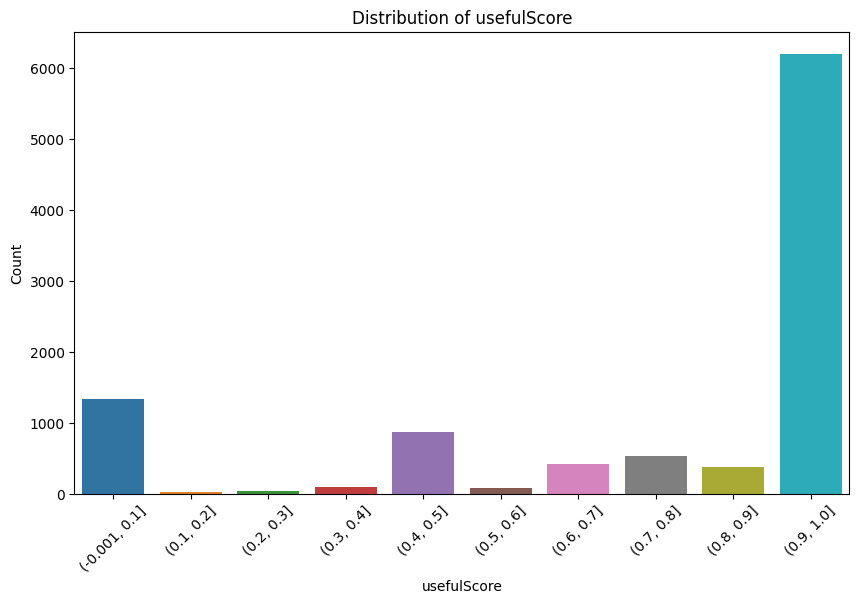

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 sample_data 包含了你的数据
# 例如：sample_data = pd.read_csv('your_data.csv')

# 将 usefulScore 列的值分成十个区间
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()

# 绘制 barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('usefulScore')
plt.ylabel('Count')
plt.title('Distribution of usefulScore')
plt.xticks(rotation=45)
plt.show()


# 样本不均衡，AUC=0.5


In [42]:
b

0.000000    1331
0.052632       1
0.055556       1
0.074074       1
0.083333       2
            ... 
0.985294       1
0.986301       1
0.987500       1
0.995614       1
1.000000    5885
Name: usefulScore, Length: 197, dtype: int64

In [43]:
from sklearn.preprocessing import MinMaxScaler

# 初始化MinMaxScaler
scaler = MinMaxScaler()


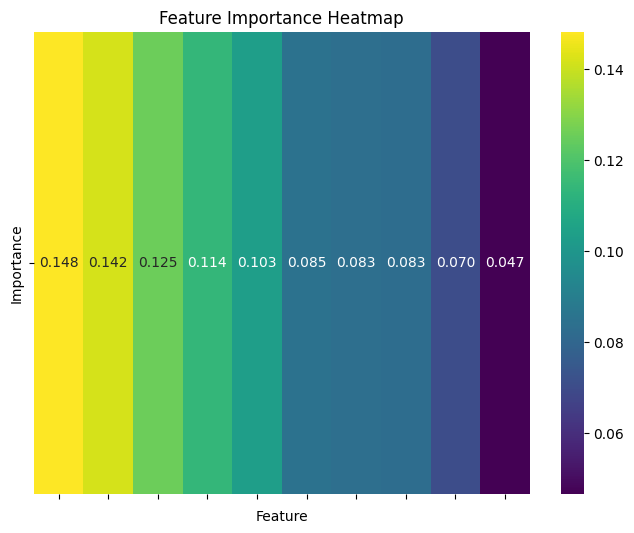

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels


y = sample_data['usefulScore'].values
X = sample_data.drop(columns='usefulScore')

#######数不需要归一化

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({'Feature': sample_data.columns.tolist().remove('usefulScore'),
                              'Importance': feature_importances})


# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap_data = importance_df.set_index('Feature')['Importance'].sort_values(ascending=False).to_frame().T
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.3f')
plt.title('Feature Importance Heatmap')
plt.show()

In [199]:
# 不用交叉验证，没必要，时间长，结果差不多
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


y = sample_data['usefulScore'].values
X = sample_data.drop(columns='usefulScore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [194]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
threshold = 0.4

In [195]:
#################处理样本不平衡

from sklearn.utils import resample

# 将数据分成特征 (X) 和目标 (y)
# 替换成你的特征数据
y = sample_data['usefulScore']  # 替换成你的目标数据

y.value_counts()


1.000000    5885
0.000000    1331
0.500000     868
0.666667     386
0.750000     296
            ... 
0.642857       1
0.958678       1
0.074074       1
0.964286       1
0.545455       1
Name: usefulScore, Length: 197, dtype: int64

# 平衡样本

In [200]:

# 将数据分成正例和负例
positive_samples = sample_data[y > threshold]
negative_samples = sample_data[y <= threshold]

# 从负例中随机采样生成合成样本
synthetic_samples = resample(negative_samples, n_samples=len(positive_samples), random_state=42)

# 将正例和合成样本合并
balanced_data = pd.concat([positive_samples, synthetic_samples])

# balanced_data 包含了处理后的平衡数据，你可以将其用于训练模型
X = balanced_data.drop(columns='usefulScore')
y = balanced_data['usefulScore'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [151]:
balanced_data['usefulScore'].value_counts()

0.000000    7525
1.000000    5885
0.500000     868
0.333333     475
0.666667     386
            ... 
0.837838       1
0.972603       1
0.828571       1
0.926829       1
0.074074       1
Name: usefulScore, Length: 197, dtype: int64

In [117]:

##################随机森林

##过拟合，减少树的数量

rf_model = RandomForestClassifier(n_estimators=20, random_state=42)  #100->10

# 使用交叉验证评估模型性能
# cv 参数指定了将数据集分成几份进行交叉验证，这里使用了 5 折交叉验证
# scoring 参数指定了评估指标，比如 'accuracy' 代表准确率
scores = cross_val_score(rf_model, X_train, y_train_binary, cv=5, scoring='accuracy')
rf_model.fit(X_train,y_train_binary)

# 输出交叉验证的结果
print("Cross-validated Accuracy:", scores)
print("Mean Accuracy:", scores.mean())

# 在测试集上评估模型性能
accuracy = rf_model.score(X_test, y_test_binary)
print(f'Test Accuracy: {accuracy}')

Cross-validated Accuracy: [0.93090775 0.93127527 0.92870268 0.92279412 0.92647059]
Mean Accuracy: 0.9280300819335453
Test Accuracy: 0.9482505145545428


In [118]:
y_test_binary.mean()

0.5092619817700677

In [119]:
from sklearn.base import r2_score
from sklearn.metrics import roc_auc_score
# 使用 roc_auc_score 函数计算AUC
y_pred = rf_model.predict(X_test)
y_pred_binary = (rf_model.predict(X_test) > threshold).astype(int)
auc_score = roc_auc_score(y_test_binary, y_pred_binary)

print(f"AUC Score: {auc_score}")
r2 = r2_score(y_test, y_pred)
print(r2)

AUC Score: 0.9489846432085149
0.6915277029991969


# 每个变量

In [210]:


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = sample_data.columns.tolist()
features.remove('usefulScore')
outcome = []
threshold = 0.4

for i in features:
    X_train1 = X_train[[i]].values.reshape(-1, 1)  # Use the feature 'i'
    X_test1 = X_test[[i]].values.reshape(-1, 1) 

    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)
    # Train the model
    rf_model.fit(X_train1, y_train_binary)
    y_test_binary = (y_test > threshold).astype(int)
    y_pred_binary = (rf_model.predict(X_test1) > threshold).astype(int)
    y_pred = rf_model.predict(X_test1) 

    # Evaluate the model
    accuracy = roc_auc_score(y_test_binary, y_pred_binary)
    r2 = r2_score(y_test, y_pred)
    outcome.append(f'AUC for {i}: {accuracy} ')
outcome

['AUC for overall: 0.5748202516476932 ',
 'AUC for unixReviewTime: 0.6774357700604835 ',
 'AUC for Review_Interval_Days: 0.6788791880743403 ',
 'AUC for Readability_smog: 0.5709651407198513 ',
 'AUC for Readability_flesch: 0.5767875897530985 ',
 'AUC for Readability_Gunning: 0.6295303780250374 ',
 'AUC for Readability_char_count: 0.6316819270573162 ',
 'AUC for Word_Count: 0.5838367278881159 ',
 'AUC for Polarity: 0.7584908264688098 ',
 'AUC for Subjectivity: 0.7533163155877384 ']